# RICA ALGORITHM FOR COMPUTING CAUSAL EFFECT IN IV GRAPH

Here you can run all the code easily. My impression is that RICA doesn't work in our case, but I might be missing something and/or have done something wrong in the code.
You'll find Two scenarios for the simulation:
1. Initial Point the true value
2. Random inizialization

for each of the two scenarios you'll see the simulations, one for the case we observe the whole graph and the other in which we have the hidden variable. My conclusion, in a nutshell are:
1. Both in the fully observed and the hidden variable case, seems that the true point is not a local minima of the loss function. 
2. In the fully observed case, the loss function and the error on the causal effect seems to be somewhat correlated while in the case with the hidden variable doesn't seem so.


In [1]:
import networkx as nx
import numpy as np
import torch
from torch.nn import Parameter
import matplotlib.pyplot as plt
import random 

random.seed(10)

## Functions

In [2]:
import networkx as nx
import numpy as np
import torch
from torch.nn import Parameter
import matplotlib.pyplot as plt




def hid_var_dag(latent=2,observed=5,dag_type = 'default',parents_max = 3,
                expected_degree=3):
    
    """
        Generate random Directed Acyclic Graphs (DAGs) with hidden variables.
        
        Parameters:
        - latent (int): Number of hidden variables.
        - observed (int): Number of observed variables.
        - dag_type (str): Type of DAG to generate ('default' or 'erdos').
        - parents_max (int): Maximum number of parents for observed variables in the 'default' DAG type.
        - expected_degree (int): Expected degree of nodes in the 'erdos' DAG type.
        
        Returns:
        - g (nx.DiGraph): Generated DAG as a NetworkX DiGraph object.
        
    """
    
    adj = np.zeros((latent+observed, latent+observed))
    for i in range(latent):
        obs_ch = np.random.randint(latent,latent+observed,np.random.randint(2,observed+1))
        for j in obs_ch:
            adj[i,j] = 1;
            
    if dag_type == 'default':
        for j in range(1, observed):
            nb_parents = np.random.randint(0, min([parents_max, j])+1)
            for i in np.random.choice(range(0, j), nb_parents, replace=False):
                adj[latent+i,latent+j] = 1

    elif dag_type == 'erdos':
        nb_edges = expected_degree * observed
        prob_connection = 2 * nb_edges/(observed**2 - observed)
        causal_order = np.random.permutation(np.arange(observed))

        for i in range(observed - 1):
            node = causal_order[i]
            possible_parents = causal_order[(i+1):]
            num_parents = np.random.binomial(n=observed - i - 1,
                                             p=prob_connection)
            parents = np.random.choice(possible_parents, size=num_parents,
                                       replace=False)
            adj[latent+parents,latent+node] = 1      
            
    g = nx.DiGraph(adj)            
    return g



def hid_var_data(latent=2,observed=5,g = None, n = 500, 
                 withening = True):
    """
    Generate, possibly whitened, data from a given DAG.
    
    Parameters:
        - latent (int): Number of hidden variables.
        - observed (int): Number of observed variables.
        - g (nx.DiGraph): The DAG as a NetworkX DiGraph object.
        - n (int): Number of data samples to generate.
        - withening (bool): Flag to apply whitening to the data.
    
    Returns:
        - data (torch.Tensor): Generated data.
        - adj (torch.Tensor): Adjacency matrix of the DAG.
        - W_with (torch.Tensor): Whitening matrix (if applicable otherwise identity matrix).
        - weight (torch.Tensor): Weights associated with the DAG edges.
    
    """
    weight =10*torch.Tensor(len(g.edges())).normal_()
    
    adj = torch.eye(len(g.nodes()))
    for e in range(len(g.edges())):
        adj[list(g.edges)[e]]=-weight[e]
    B = (torch.inverse(adj)).t()
    
    err = torch.Tensor(latent+observed,n).cauchy_()
    data = B.matmul(err).t()
    data = data[:,latent:(observed+1)]
    d_cov = (data.t()).cov()
    
    if withening == True:
        U, S, V = d_cov.svd()
        S_2=torch.inverse(torch.diag(S.sqrt()))
        W_with = S_2.matmul(V.t())
        data = W_with.matmul(data.t()).t()
        
        return data, adj, W_with, weight
    
    return data, adj,torch.eye(observed) ,weight


def graphical_rica(latent, observed, g, data, moms, lambdas, epochs, lr, W_with, pseudoinverse, w_init, w_true):
    
    """
        Perform the optimization task for graphical Independent Component Analysis (ICA).
        
        Parameters:
            - latent (int): Number of hidden variables.
            - observed (int): Number of observed variables.
            - g (nx.DiGraph): The DAG as a NetworkX DiGraph object.
            - data (torch.Tensor): Input data.
            - moms (list): List of momentum values for optimization.
            - lambdas (list): List of regularization lambda values for optimization.
            - epochs (int): Number of optimization epochs.
            - W_with (torch.Tensor): Whitening matrix.
            - pseudoinverse (bool): Flag to use pseudoinverse.
            - w_init (str): Weight initialization strategy ('random' or 'true').
            - w_true (torch.Tensor): True weights of the DAG edges.
        
        Returns:
            - loss_data (torch.Tensor): Loss data during optimization.
            - loss_recon_data (torch.Tensor): Reconstruction loss data during optimization.
            - loss_latent_data (torch.Tensor): Latent loss data during optimization.
            - w_loss_data (torch.Tensor): Weight loss data during optimization.
            
        """
    
    loss_data = torch.zeros(len(moms),len(lambdas),epochs)
    loss_recon_data =  torch.zeros(len(moms),len(lambdas),epochs)
    loss_latent_data = torch.zeros(len(moms),len(lambdas),epochs)
    w_loss_data = torch.zeros(len(w_true),len(moms),len(lambdas),epochs)
    

                
    for i in range(len(moms)):
        for j in range(len(lambdas)):
            
            if w_init == 'random':
                weight = Parameter(torch.Tensor(len(g.edges())).normal_())
            else :
                weight = Parameter(torch.clone(w_true).detach().requires_grad_(True))
            
            mom = moms[i]
            lambd = lambdas[j]
            optimizer = torch.optim.RMSprop([weight], lr, momentum=mom)
            

            for epoch in range(epochs):
                    
                adj = torch.eye(len(g.nodes()))
                for e in range(len(g.edges())):
                    adj[list(g.edges)[e]]=-weight[e]
                
                B = (torch.inverse(adj)).t()
                B = B[latent:latent+observed,:]
                B = W_with.matmul(B)
                
                if pseudoinverse == True:
                    B = B.matmul((B.t().matmul(B)).inverse())

                latents = data.matmul(B)
                output = latents.matmul(B.t())
            
                
                diff = output - data
                loss_recon = (diff * diff).mean()
                loss_latent = latents.abs().mean()
                loss =lambd * loss_recon + loss_latent
                
                
                loss_data[i, j, epoch] =  (loss.data).item()
                loss_recon_data[i, j, epoch] =  (loss_recon.data).item()
                loss_latent_data[i, j, epoch] =  (loss_latent.data).item()
               
                w_loss_data[:,i,j, epoch] = (weight-torch.tensor(w_true)).square()       
                
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                

    return loss_data, loss_recon_data, loss_latent_data, w_loss_data


def loss_plots(loss_data, loss_recon_data, loss_latent_data, w_loss_data, moms, lambdas, epochs):
    """
    Generate and display plots.

    Parameters:
    - loss_data (torch.Tensor): Loss data during optimization.
    - loss_recon_data (torch.Tensor): Reconstruction loss data during optimization.
    - loss_latent_data (torch.Tensor): Latent loss data during optimization.
    - w_loss_data (torch.Tensor): Weight loss data during optimization.
    - moms (list): List of momentum values.
    - lambdas (list): List of regularization lambda values.
    - epochs (int): Number of optimization epochs.
    """

    fig, axs = plt.subplots(len(moms), len(lambdas), figsize=(12, 8))

    for i in range(len(moms)):
        for j in range(len(lambdas)):
            x = range(epochs)

            # Plot on the current subplot
            ax1 = axs[i, j]
            line1, = ax1.plot(x, loss_data[i, j, :], 'b-', label='Loss Data')
            ax1.set_xlabel('Epochs')
            ax1.set_ylabel('Loss Data', color='b')
            ax1.tick_params('y', colors='b')

            # Create a second y-axis on the same subplot
            ax2 = ax1.twinx()
            lines2 = []
            for k in range(4):
                line2, = ax2.plot(x, w_loss_data[k, i, j, :].detach().numpy(), linestyle='--', label=f'W_{k} Loss')
                lines2.append(line2)
            ax2.set_ylabel('W Loss', color='r')
            ax2.tick_params('y', colors='r')

            # Combine legends from both subplots
            lines = [line1] + lines2
            labels = [line.get_label() for line in lines]
            ax1.legend(lines, labels, loc='upper right')

            ax1.set_title(f'Lambda: {lambdas[j]}, Mom: {moms[i]}')

    # Adjust layout and display the plots
    plt.tight_layout()
    plt.show()

### IV GRAPH 

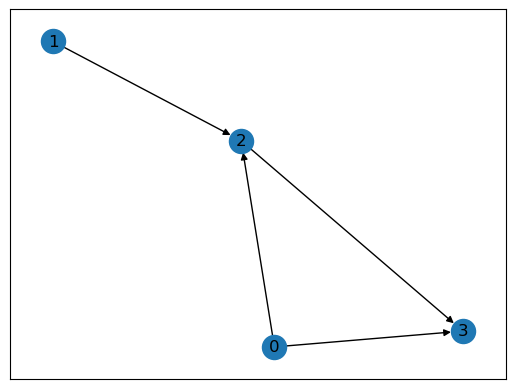

In [3]:
iv_adj = np.array([[0,0,1,1],[0,0,1,0],[0,0,0,1],[0,0,0,0]])
g = nx.DiGraph(iv_adj)
nx.draw_networkx(g)

### Hyperparamters shared across all the simulations
**lambdas** are the regularization parameters to use in the loss function<br>
**moms** the momentums for the optimization<br>
**withening** decides wheter to use the withened data or not.

In [4]:
lambdas = [0,10]
moms = [0,1]
epochs = 300
withening = True

## TRUE VALUE AS INITIAL POINT

### Data Generation (fully observed case)

In [5]:
latent = 0
observed = 4
n = 10000
lr = 0.0001
pseudoinverse = True
w_init = 'given'

data, params, W_with, w_true = hid_var_data(latent, observed, g ,n, withening)

### Optimization and plots

/var/folders/nd/nn8th6r16cq6sytrzw1nw_9w0000gn/T/ipykernel_46510/1356351102.py:174: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  w_loss_data[:,i,j, epoch] = (weight-torch.tensor(w_true)).square()


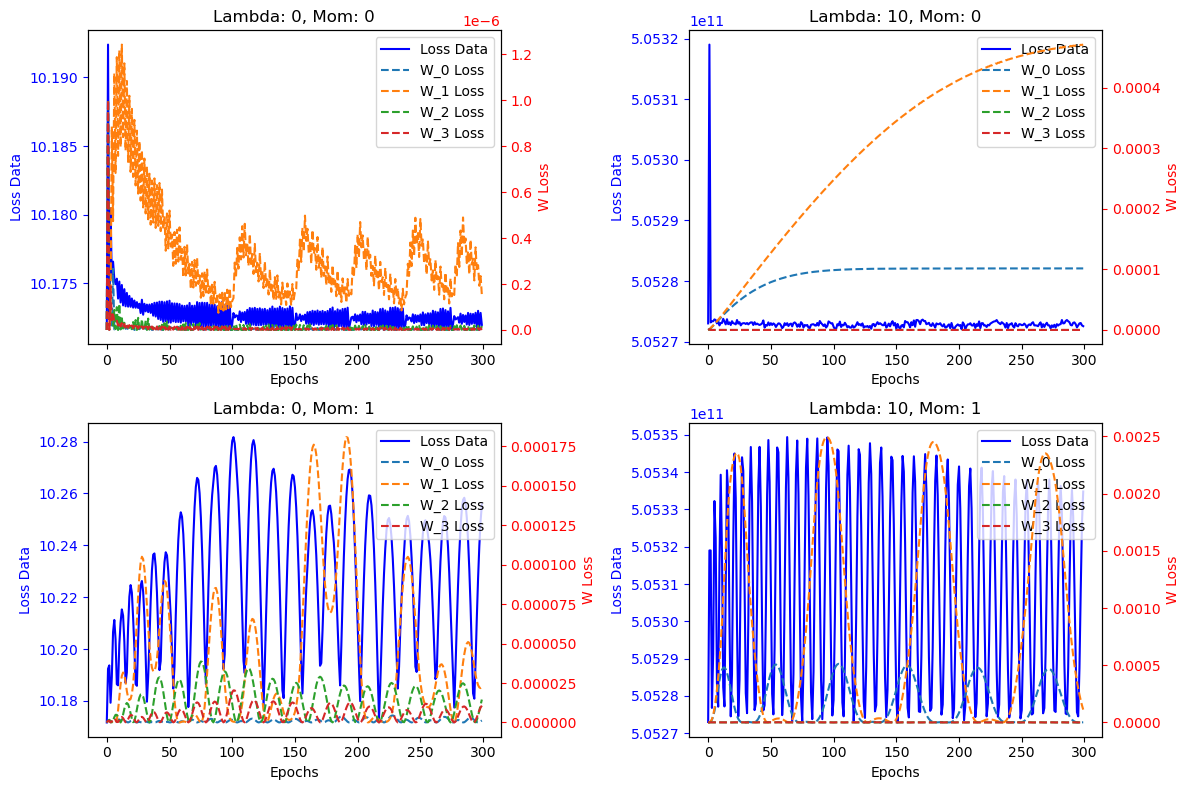

In [6]:
loss_data, loss_recon_data, loss_latent_data, w_loss_data = graphical_rica(latent, observed, g, data, 
                                                                           moms, lambdas, epochs, lr, W_with, pseudoinverse,
                                                                           w_init, w_true) 

loss_plots(loss_data, loss_recon_data, loss_latent_data, w_loss_data,moms, lambdas, epochs)

### Data generation with hidden variable

In [7]:
latent = 1
observed = 3
lr = 0.0001
pseudoinverse = False
w_init = 'given'


data, params, W_with, w_true = hid_var_data(latent, observed, g ,n, withening)

### Optimization and plots

/var/folders/nd/nn8th6r16cq6sytrzw1nw_9w0000gn/T/ipykernel_46510/1356351102.py:174: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  w_loss_data[:,i,j, epoch] = (weight-torch.tensor(w_true)).square()


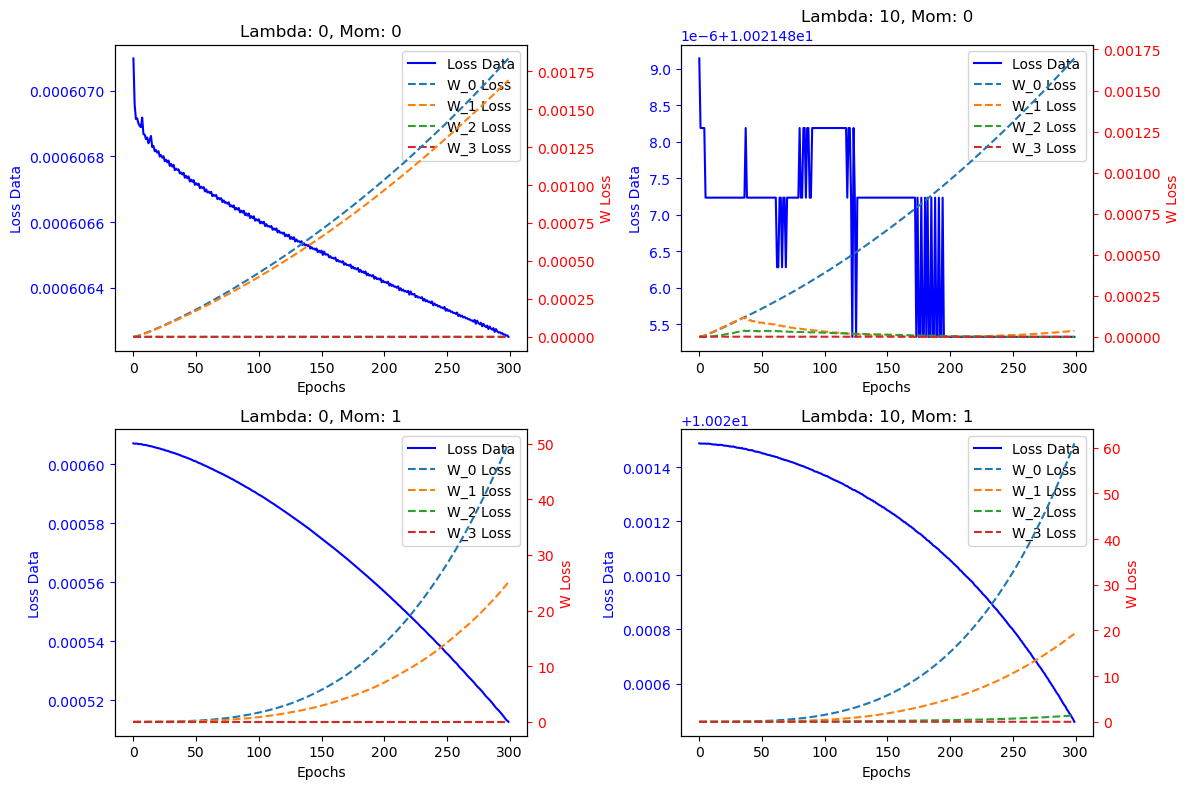

In [8]:
loss_data, loss_recon_data, loss_latent_data, w_loss_data = graphical_rica(latent, observed, g, data, 
                                                                           moms, lambdas, epochs, lr, W_with, pseudoinverse,
                                                                           w_init, w_true) 

loss_plots(loss_data, loss_recon_data, loss_latent_data, w_loss_data,moms, lambdas, epochs)

## RANDOM INIZIALIZATION

### DATA GENERATION (FULLY OBSERVED CASE)

In [9]:
latent = 0
observed = 4
lr = 0.01
pseudoinverse = True
w_init = 'random'

In [10]:
data, params, W_with, w_true = hid_var_data(latent, observed, g ,n, withening)

### OPTIMIZATION AND PLOTS

/var/folders/nd/nn8th6r16cq6sytrzw1nw_9w0000gn/T/ipykernel_46510/1356351102.py:174: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  w_loss_data[:,i,j, epoch] = (weight-torch.tensor(w_true)).square()


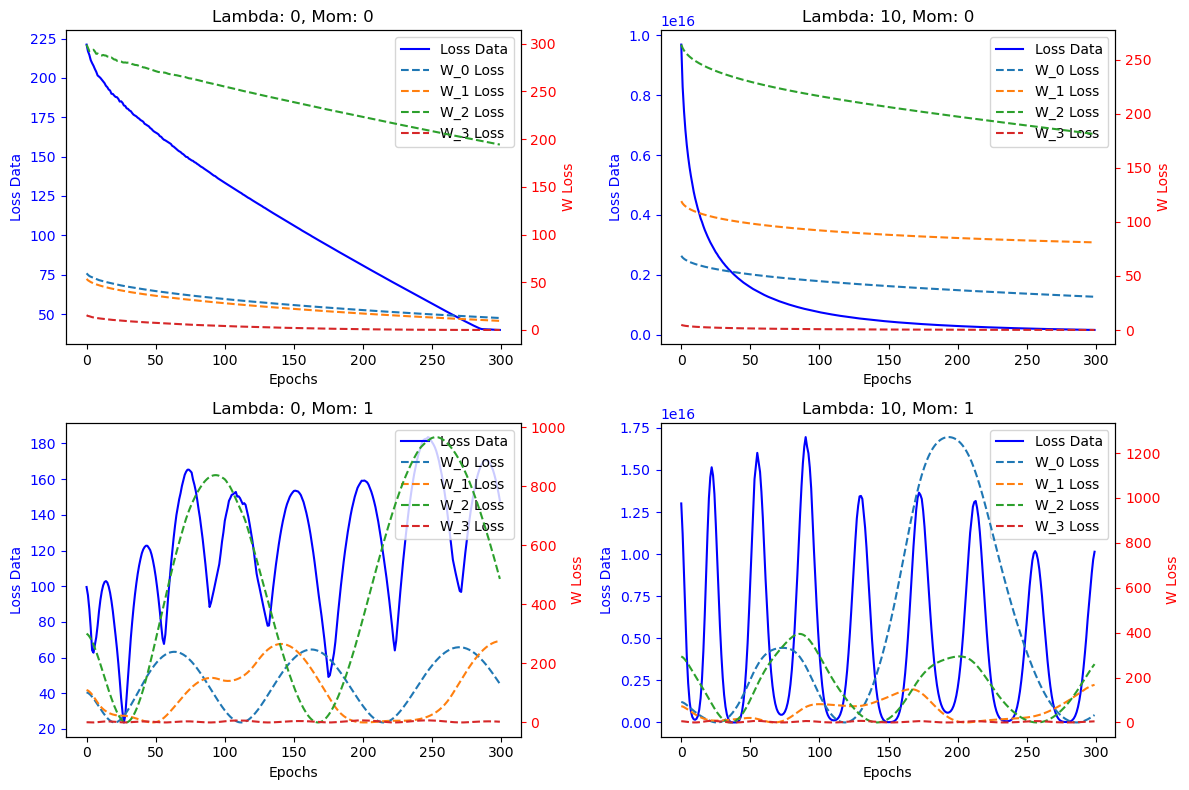

In [11]:
loss_data, loss_recon_data, loss_latent_data, w_loss_data = graphical_rica(latent, observed, g, data, 
                                                                           moms, lambdas, epochs, lr, W_with, pseudoinverse,
                                                                           w_init, w_true) 

loss_plots(loss_data, loss_recon_data, loss_latent_data, w_loss_data,moms, lambdas, epochs)

### DATA GENERATION WITH HIDDEN VARIABLES

In [12]:
latent = 1
observed = 3
lr = 0.01
epochs = 300
pseudoinverse = False
w_init = 'random'

data, params, W_with, w_true = hid_var_data(latent, observed, g ,n, withening)

### OPTIMIZATION AND PLOTS

/var/folders/nd/nn8th6r16cq6sytrzw1nw_9w0000gn/T/ipykernel_46510/1356351102.py:174: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  w_loss_data[:,i,j, epoch] = (weight-torch.tensor(w_true)).square()


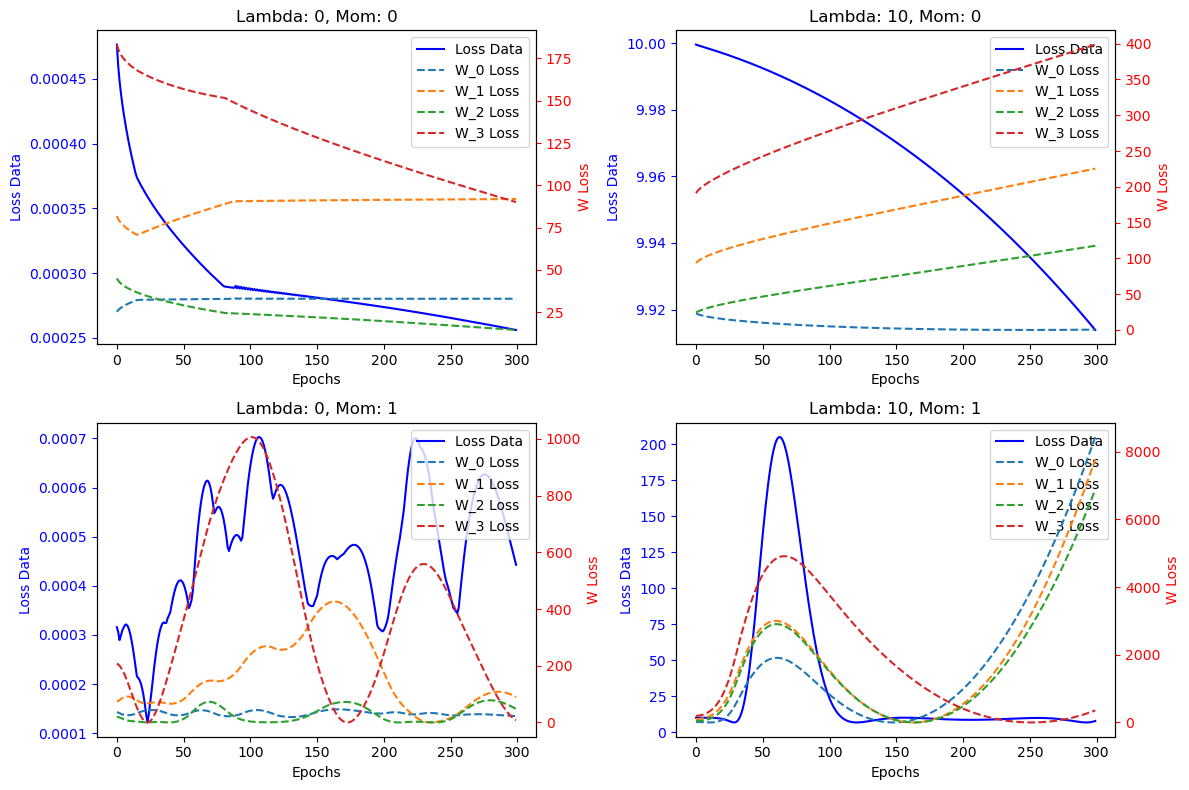

In [13]:
loss_data, loss_recon_data, loss_latent_data, w_loss_data = graphical_rica(latent, observed, g, data, 
                                                                           moms, lambdas, epochs, lr, W_with, pseudoinverse,
                                                                           w_init, w_true) 

loss_plots(loss_data, loss_recon_data, loss_latent_data, w_loss_data,moms, lambdas, epochs)